In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *

import tensorflow as tf
import cv2
import random
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
import numpy as np
import glob
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [ ]:
import keras_applications

In [ ]:
backend = {"backend": tf.keras.backend, 
          "layers": tf.keras.layers, 
          "models": tf.keras.models,
          'utils': tf.keras.utils}

In [ ]:
images_size = (512, 512)
model1 = keras_applications.densenet.DenseNet([10, 10, 10, 10],
             False,
             None,
             None,
             (*images_size, 3),
             'avg',
             2,
             **backend)

model2 = keras_applications.densenet.DenseNet([10, 10, 10, 10],
             False,
             None,
             None,
             (*images_size, 3),
             'avg',
             2,
             **backend)

model3 = keras_applications.densenet.DenseNet([10, 10, 10, 10],
             False,
             None,
             None,
             (*images_size, 3),
             'avg',
             2,
             **backend)

model4 = keras_applications.densenet.DenseNet([10, 10, 10, 10],
             False,
             None,
             None,
             (*images_size, 3),
             'avg',
             2,
             **backend)

model5 = keras_applications.densenet.DenseNet([10, 10, 10, 10],
             False,
             None,
             None,
             (*images_size, 3),
             'avg',
             2,
             **backend)

model6 = keras_applications.densenet.DenseNet([10, 10, 10, 10],
             False,
             None,
             None,
             (*images_size, 3),
             'avg',
             2,
             **backend)

In [ ]:
input_img = Input(shape = (*images_size, 3))

model_BGR =  Sequential(Model(input_img, model1(input_img)))
model_BGR.add(Flatten())

model_HSV = Sequential(Model(input_img, model2(input_img)))
model_HSV.add(Flatten())


# model_YUV = Model(input_img, model(input_img))
model_YUV = Sequential(Model(input_img, model3(input_img)))
model_YUV.add(Flatten())

# model_LAB = Model(input_img, model(input_img))
model_LAB = Sequential(Model(input_img, model4(input_img)))
model_LAB.add(Flatten())

model_HED = Sequential(Model(input_img, model5(input_img)))
model_HED.add(Flatten())

model_XYZ = Sequential(Model(input_img, model6(input_img)))
model_XYZ.add(Flatten())

In [ ]:
x = concatenate(inputs=[model_BGR.output, model_HSV.output, model_YUV.output,
                       model_LAB.output, model_HED.output, model_XYZ.output])

In [ ]:
z = Dense(2, activation="softmax")(x)
# our model will accept the inputs of the two branches and
# then output a single value
model_comb = Model(inputs=[model_BGR.input, model_HSV.input, model_YUV.input, 
                          model_LAB.input, model_HED.input, model_XYZ.input], outputs=z)

In [ ]:
model_comb.summary()

In [ ]:
from skimage.color import rgb2hed

In [6]:
def changeColorSpace(img, flag):
    if flag == 'flag_HED':
        img = rgb2hed(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        return img#/np.max(img)
    else:
        img = cv2.cvtColor(img, flag)
        return img#/np.max(img)

In [7]:
flag_HSV = cv2.COLOR_BGR2HSV
flag_YUV = cv2.COLOR_BGR2YUV
flag_LAB = cv2.COLOR_BGR2LAB
flag_HED = 'flag_HED'
flag_XYZ = cv2.COLOR_BGR2XYZ
flag_YCR_CB = cv2.COLOR_BGR2YCR_CB

In [17]:
img = cv2.imread('../../Cover/00110.jpg')#, cv2.COLOR_BGR2RGB)

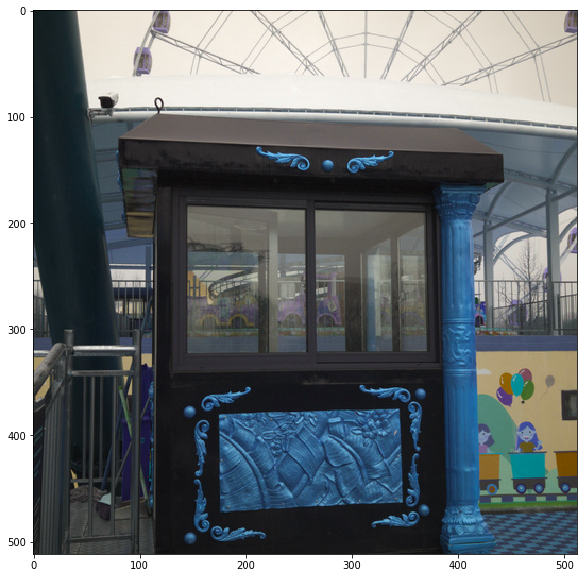

In [18]:
plt.imshow(img)

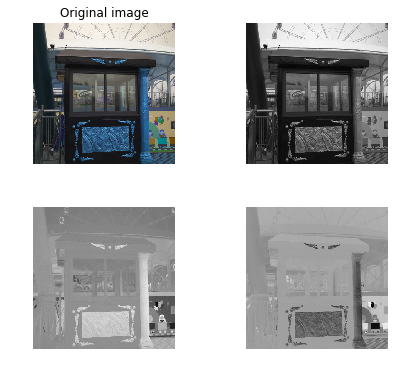

In [19]:
img_hed = changeColorSpace(img, flag_YCR_CB)

fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(img)
ax0.set_title("Original image")

ax1.imshow(img_hed[:, :, 0], cmap=plt.cm.gray)

ax2.imshow(img_hed[:, :, 1], cmap=plt.cm.gray)
#ax2.set_title("Eosin")

ax3.imshow(img_hed[:, :, 2], cmap=plt.cm.gray)
#ax3.set_title("DAB")

for ax in axes.ravel():
    ax.axis('off')

fig.subplots_adjust(hspace=0.3)

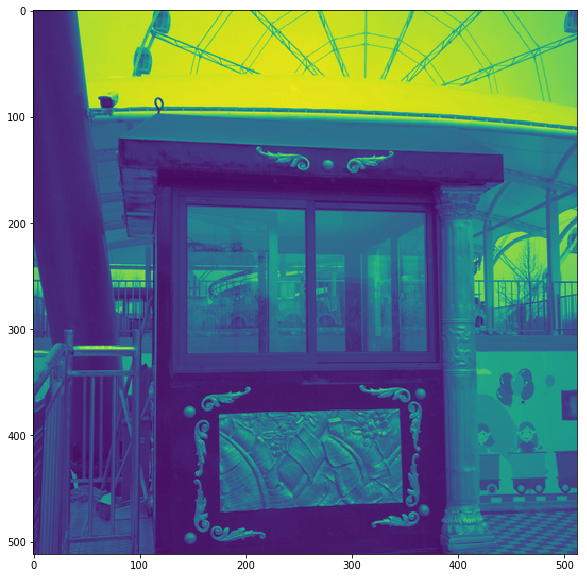

In [25]:
plt.imshow(img_hed[:, :, 0])

In [ ]:
def get_image_data(image_id, image_size):
    img = cv2.imread(image_id)
    h, w = image_size
    crop_img = img[0:h, 0:w]
    return crop_img

def get_label(image_id):
    if 'Cover' in image_id:
        return [1,0]
    else:
        return [0,1]

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1, 
                 shuffle=True, number_of_labels=2, flag=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.number_of_labels = number_of_labels
        self.flag = flag
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        """Getting items from the 2 generators and packing them"""

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        # cv2 recevrses height and width
        return [X[0], X[1], X[2], X[3], X[4], X[5]], y
#         return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim[::-1], self.n_channels))
#         y = np.empty((self.batch_size, *self.dim[::-1]))
        X = np.empty((6, self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.number_of_labels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = get_image_data(ID, self.dim)
            X[0,i] = img/np.max(img)
            X[1,i] = changeColorSpace(img, flag_HSV)
            X[2,i] = changeColorSpace(img, flag_YUV)
            X[3,i] = changeColorSpace(img, flag_LAB)
            X[4,i] = changeColorSpace(img, flag_HED)
            X[5,i] = changeColorSpace(img, flag_XYZ)
            
            y[i,:] = get_label(ID)
                    
        return X, y

In [ ]:
input_dir = '/kaggle/input/alaska2-image-steganalysis/'
limit = 250
cover_imgs = glob.glob(input_dir+'Cover/*.jpg')
#random.Random(4).shuffle(cover_imgs)
cover_imgs = cover_imgs[:limit]

jmipod_imgs = glob.glob(input_dir+'JMiPOD/*.jpg')
#random.Random(4).shuffle(jmipod_imgs)
jmipod_imgs = jmipod_imgs[:limit]

juniward_imgs = glob.glob(input_dir+'JUNIWARD/*.jpg')
#random.Random(4).shuffle(juniward_imgs)
juniward_imgs = juniward_imgs[:limit]

uerd_imgs = glob.glob(input_dir+'UERD/*.jpg')
#random.Random(4).shuffle(uerd_imgs)
uerd_imgs = uerd_imgs[:limit]

list_IDs = cover_imgs + jmipod_imgs + juniward_imgs + uerd_imgs

random.Random(4).shuffle(list_IDs)

train_IDs = list_IDs[:int(0.8*len(list_IDs))]
test_IDs = list_IDs[int(0.8*len(list_IDs)):]

In [ ]:
params = {'dim': images_size,
          'batch_size': 1,
          'n_channels': 3,
          'shuffle': True, }

# Generators
training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(test_IDs, **params)

In [ ]:
model_comb.compile(loss=keras.losses.binary_crossentropy, 
                    metrics=['accuracy'], optimizer='adadelta')

In [ ]:
model_comb.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=5, workers=5, use_multiprocessing=True)

In [ ]:
input_dir = '/kaggle/input/alaska2-image-steganalysis/'
test_imgs = glob.glob(input_dir+'Test/*.jpg')

In [ ]:
def generateTestData(id_list, dim=images_size, n_channels=3):
    batch_size = len(id_list)
    X = np.empty((6, 1, *dim, n_channels))

    # Generate data
    for i, ID in enumerate(id_list):
        # Store sample
        img = get_image_data(ID, dim)
        X[0,i] = img/np.max(img)
        X[1,i] = changeColorSpace(img, flag_HSV)
        X[2,i] = changeColorSpace(img, flag_YUV)
        X[3,i] = changeColorSpace(img, flag_LAB)
        X[4,i] = changeColorSpace(img, flag_HED)
        X[5,i] = changeColorSpace(img, flag_XYZ)
    return [X[0], X[1], X[2], X[3], X[4], X[5]]

In [ ]:
preds = []
for i in range(0, 5000, 1):
    X = generateTestData(test_imgs[i:i+1])
    y_pred = model_comb.predict(X)
    preds.append([test_imgs[i].split('/')[-1], y_pred[0][1]])
    if i % 50 == 0:
        print(i)

In [ ]:
preds[0]

In [ ]:
df = pd.DataFrame(preds, columns=["Id", "Label"])
df.sort_values(['Id'], inplace=True)

In [ ]:
df.to_csv('submission.csv', index=False)